# Testing of the patt_mcmc module's different samplers

In [1]:
from patt_mcmc import *
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import matplotlib.pyplot as plt

In [2]:
n_chains = 10
n_burn = int(1e4)
n_its = int(1e5)

### GPSS

In [3]:
d = 100
x_0s = rnd.normal(scale=d, size=(n_chains,d))
w_burn = d**2
w_att = d

In [4]:
c = np.arange(d)

# multivariate Cauchy distribution with substantially non-zero center but trivial shape parameter
def log_density(x):
    return -(d+1)/2 * np.log(1 + alg.norm(x - c)**2)

In [5]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="medi",
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [6]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
medians = ret_dic['medians']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']

In [7]:
print("TDE/it: {:.2f}, standard dev: {:.2f}".format(np.mean(tde_cnts[1:]), np.std(tde_cnts[1:])))

TDE/it: 7.50, standard dev: 64.87


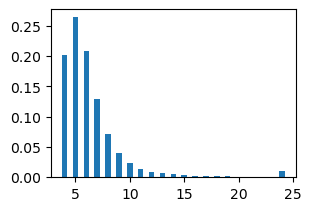

In [8]:
maxcnt = int(np.quantile(tde_cnts, 0.99))
filtered_tde_cnts = np.array([np.min([cnt, maxcnt]) for cnt in tde_cnts[1:].reshape(-1)])
pfs.plot_tde_distr(filtered_tde_cnts)

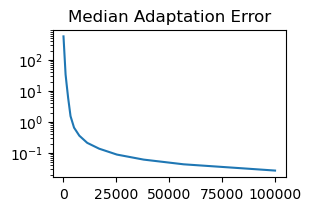

In [9]:
pfs.plot_ada_progress_testing(schedule, medians, c, "Median")

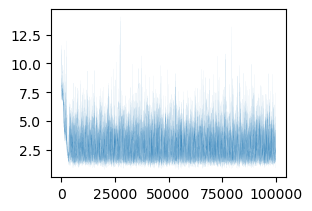

In [10]:
log_dist_from_c = mcu.get_log_radii(samples[:,0] - c)
pfs.trace_plot(log_dist_from_c)

### HRUSS

In [11]:
d = 37
x_0s = rnd.normal(scale=1, size=(n_chains,d))
w_burn = d
w_att = d

In [12]:
std = np.arange(1,d+1)

# mean zero Gaussian with highly inconsistent coordinate variances
def log_density(x):
    return -alg.norm(x / std)**2 / 2

In [13]:
ret_dic = patt_hruss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cov_mode="var",
    w_burn=w_burn,
    w_att=w_att
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [14]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
std_devs = ret_dic['std_devs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']

In [15]:
print("TDE/it: {:.2f}, standard dev: {:.2f}".format(np.mean(tde_cnts[1:]), np.std(tde_cnts[1:])))

TDE/it: 6.78, standard dev: 2.55


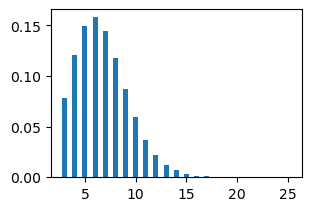

In [16]:
pfs.plot_tde_distr(tde_cnts[1:])

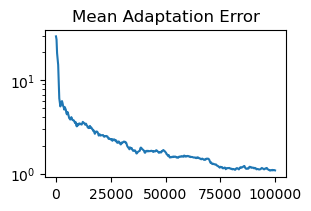

In [17]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

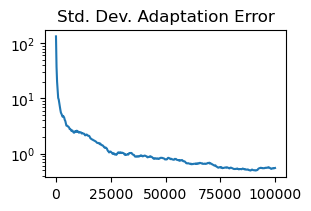

In [18]:
pfs.plot_ada_progress_testing(schedule, std_devs, std, "Std. Dev.")

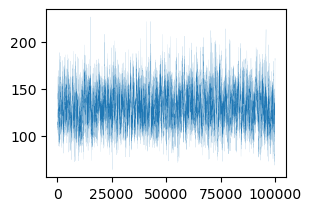

In [19]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii, lw=0.05)

### RSUSS

In [20]:
d = 29
x_0s = rnd.normal(scale=1, size=(n_chains,d))
w_burn = 1
w_att = 1

In [21]:
corr = 0.95
cov = np.full((d,d), corr) + (1 - corr) * np.identity(d)
inv_cov = alg.inv(cov)

# mean zero Gaussian with strongly correlated variables
def log_density(x):
    return -np.inner(x, inv_cov @ x) / 2

In [22]:
ret_dic = patt_rsuss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cov_mode="cov",
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [23]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
covs = ret_dic['covs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']

In [24]:
print("TDE/it: {:.2f}, standard dev: {:.2f}".format(np.mean(tde_cnts[1:]), np.std(tde_cnts[1:])))

TDE/it: 6.53, standard dev: 1.47


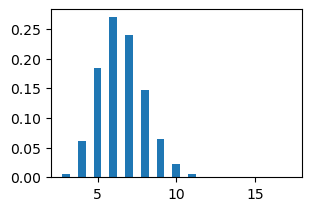

In [25]:
pfs.plot_tde_distr(tde_cnts[1:])

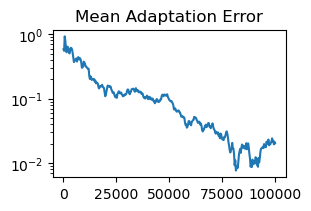

In [26]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

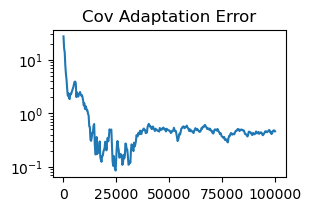

In [27]:
pfs.plot_ada_progress_testing(schedule, covs.reshape(-1, d*d), cov.reshape(-1, d*d), "Cov")

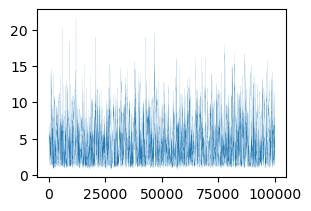

In [28]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii, lw=0.05)

### ESS

In [29]:
d = 23
x_0s = rnd.normal(scale=1, size=(n_chains,d))

In [30]:
c = np.full(d, np.sqrt(d))

# generalized Gaussian with somewhat non-zero mean but trivial covariance
def log_density(x):
    return -alg.norm(x - c)**3

In [31]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/100001 [00:00<?, ?it/s]

Assembling output...


In [32]:
burn_in = ret_dic['burn-in']
tde_cnts_burn = ret_dic['tde_cnts_burn']
samples = ret_dic['samples']
means = ret_dic['means']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']

In [33]:
print("TDE/it: {:.2f}, standard dev: {:.2f}".format(np.mean(tde_cnts[1:]), np.std(tde_cnts[1:])))

TDE/it: 5.45, standard dev: 3.07


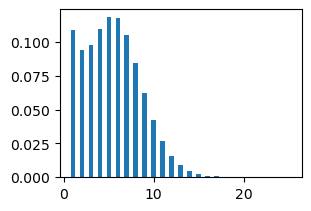

In [34]:
pfs.plot_tde_distr(tde_cnts[1:])

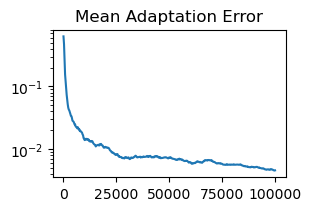

In [35]:
pfs.plot_ada_progress_testing(schedule, means, c, "Mean")

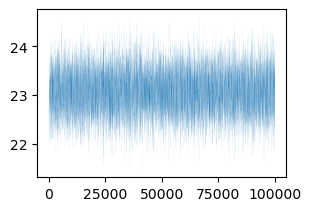

In [36]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii)